# CIFAR-10 classification with ResNet
Includes pytorch regularization

In [10]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

project_name = '06-cifar10-resnet'

# Downloading dataset
# from torchvision.datasets.utils import download_url
dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [11]:
# Extract tqar file
# import tarfile
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# import os
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train'); classes

['test', 'train', 'labels.txt']


['horse',
 'airplane',
 'truck',
 'cat',
 'frog',
 'deer',
 'bird',
 'ship',
 'dog',
 'automobile']

## Data Transforms
Normalization and data augmentation

### Normalization
Doing channelwise normalization: take the mean of the red channel, green channel, blue channel separately for the cifar-10 images, also take the standard deviations of the RGB channels separately. Then it is simply (x-mean)/sigma for each channel. As a result, the mu, sigma of each channel are gonna be (0,1). This prevents the model from getting too influenced by colors (eg: So biased by grey huskys that when it sees a white one, it doesnt deteect a husky, but detects a pomeranian as it thinks all pomeranians are white (which they are not. I had a dog. I called him Toffy. He was a chocolate colored pomeranian. He ran away. I miss my dog.)

### Data Augmentation
Doing randomized data augmentation. Pad each image by 4 pixels, take random crop of size 32x32, flip horizontally with 50% prob. Apply transformation randomly each time an image is loaded, the model sees slightly different image each epoch. This leads to better generalization.

In [12]:
# ((mean of RGB), (sd of RGB))
# import torchvision.transforms as tt
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(size=32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(p=0.5),
                         tt.ToTensor(),
                         tt.Normalize(mean=stats[0], std=stats[1], inplace=True)])
# Dont augment validation data
valid_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats)]) # giving both mean and std arguments together using *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


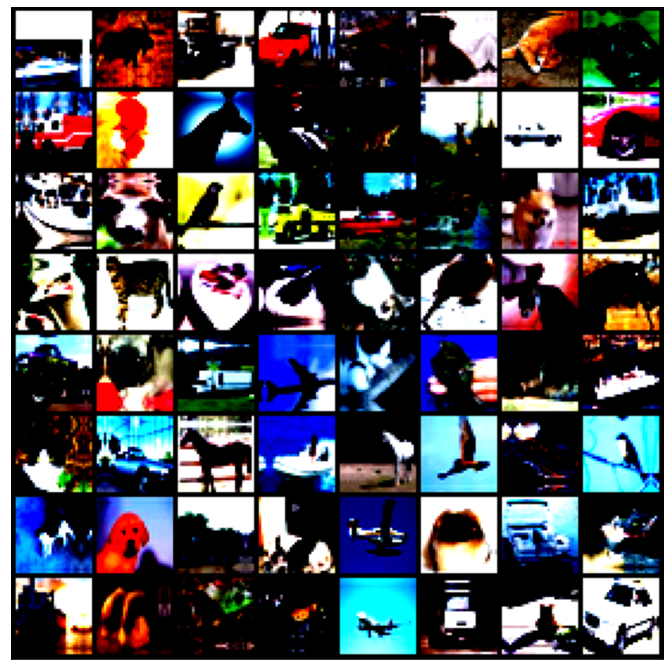

In [13]:
# Using image folder in Pytorch datasets
# from torchvision.datasets import ImageFolder
train_ds = ImageFolder(data_dir+'/train', transform=train_tfms)
valid_ds = ImageFolder(data_dir+'/test', transform=valid_tfms)

batch_size = 400

# Pytorch dataloaders
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size*2, shuffle=False, num_workers=3, pin_memory=True)

# function to show a batch
# from torchvision.utils import make_grid
def show_batch(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break
show_batch(train_dl)

In [14]:
# GPU Boilerplate
# This is so last gen

def get_default_device():
    if torch.cuda.is_available(): return torch.device('cuda')
    else: return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap dataloader to move data to device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    # Yield a batch of data after moving to device
    def __iter__(self):
        for b in self.dl: yield to_device(b, self.device)

    # Number of batches
    def __len__(self):
        return len(self.dl)

device = get_default_device(); device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Modeling

### ResNet with Residual Blocks
ResidualBlocks adds original inputs back to the output feature map obtained later in the layers. In a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away. This helps in maintaining very deep neural nets without falling prey to vanishing gradients and dimensionality curse. When we keep increasing the number of layers, the accuracy will decrease after a point, and it is not due to overfitting which occurs as usual. It is due to a problem called Degradation problem, often found in deep nets. Hence skip some extra layers using skip connections AKA Residual Blocks

So, what is this residue?

Let the input to a nn block be $x$, and the true distribution I am trying to approx is $H(X)$. The the difference between them, also known as the  residue $R(x)$ is \\

$R(x) = Output - Input$ \\
$R(x) = H(x) - x$ \\

Rearranging, we get \\
$H(x) = R(x) + x$

That means the Residual layers try to learn this difference.

For more, refer https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

This is from where I took the notes. I like the blog.


In [16]:
# See diagram from the above blog for the architecture
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

# Base class for Image classification
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # predict
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # predict
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # torch.stack() concatenates sequence of tensors along a dimension
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
# Making a reusable convolution block
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(kernel_size=2))
    return nn.Sequential(*layers)

# Implementing a Resnet9 model
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, out_channels=64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(in_channels=128, out_channels=256, pool=True)
        self.conv4 = conv_block(in_channels=256, out_channels=512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        # Making errors a lot because unlike tf, in torch.nn.Sequential(), you pass in as *args instead of a list of tf.layers objects
        # Remember in Future as well
        self.classifier = nn.Sequential(nn.MaxPool2d(kernel_size=4),
                                        nn.Flatten(),
                                        nn.Linear(in_features=512, out_features=num_classes))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Input has 3 color channels and output is a 10 class classification
model = to_device(ResNet9(3, 10), device); model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Model Training
### Improvements to the fit function

#### Learning Rate Scheduling
Using One Cycle Learning Rate Policy: Starting with a low lr, gradually increasing lr per batch till 30% training, then decreasing to very low value for the ramainder of training.

#### Weight decay
Another technique for regularization. Adding additional term to loss function to decay weights from becoming too large.

#### Gradient Clipping
Limiting the value of gradients to smaller numbers

In [20]:
@torch.no_grad() # function decorator to prevent caclculation of gradients
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Define fit method to add in lr decay, weight decay and gradClip
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    # Passing SGD stock hyperPs into opt_func in the funDef above
    # Then modding them to the following hyperPs
    # torch.optim.SGD(model.parameters(), lr=max_lr, momentum=0, dampening=0, weight_decay=weight_decay, nesterov=False)
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip: nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record and update lr
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model without training, expecting 1 in 10
history = [evaluate(model, valid_dl)]; history

[{'val_acc': 0.0962500050663948, 'val_loss': 2.306034564971924}]

In [22]:
%%time
# HyperPs
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, 
                         train_dl, valid_dl, 
                         grad_clip=grad_clip, weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 1.3160, val_loss: 1.2708, val_acc: 0.6030
Epoch [1], last_lr: 0.00759, train_loss: 0.9415, val_loss: 1.1140, val_acc: 0.6238
Epoch [2], last_lr: 0.01000, train_loss: 0.8854, val_loss: 0.6959, val_acc: 0.7648
Epoch [3], last_lr: 0.00950, train_loss: 0.6583, val_loss: 0.7417, val_acc: 0.7609
Epoch [4], last_lr: 0.00812, train_loss: 0.4950, val_loss: 0.6490, val_acc: 0.7817
Epoch [5], last_lr: 0.00611, train_loss: 0.4247, val_loss: 0.5432, val_acc: 0.8250
Epoch [6], last_lr: 0.00389, train_loss: 0.3419, val_loss: 0.3541, val_acc: 0.8785
Epoch [7], last_lr: 0.00188, train_loss: 0.2567, val_loss: 0.3077, val_acc: 0.8947
Epoch [8], last_lr: 0.00050, train_loss: 0.1844, val_loss: 0.2539, val_acc: 0.9133
Epoch [9], last_lr: 0.00000, train_loss: 0.1375, val_loss: 0.2453, val_acc: 0.9163
CPU times: user 9min 18s, sys: 7min 39s, total: 16min 58s
Wall time: 18min 1s


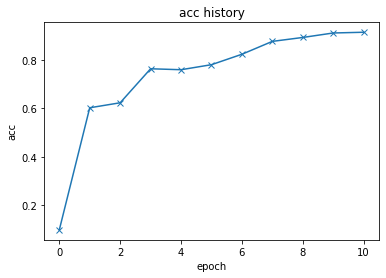

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc history')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'])
    plt.title('loss history')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch_no')
    plt.ylabel('learing rate')
    plt.title('lr vs batch.no.')

plot_accuracies(history)

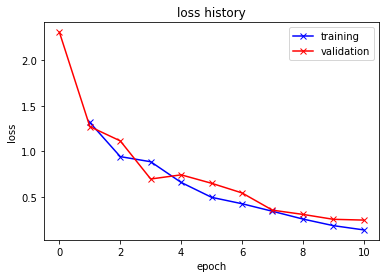

In [24]:
plot_losses(history)

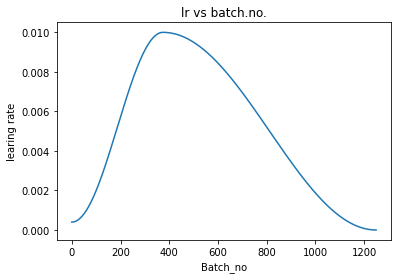

In [25]:
plot_lrs(history)

## Saving Model

In [26]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')